<a href="https://colab.research.google.com/github/jeffsengsy/Occupancy_Parking_lot_Detection/blob/main/VSModelOccupancyParkingPart3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline Model

# CNR Parking EDA Notebook

This data will be prepared in preperation for training into a model

In [ ]:
#imports
import os
import cv2
import torch
import random
import zipfile
import numpy as np
import torch.nn as nn
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

# Datasets

CNRPark+EXT.csv (18.1 MB)

CSV collecting metadata for each patch of both CNRPark and CNR-EXT datasets

CNRPark-Patches-150x150.zip (36.6 MB)

segmented images (patches) of parking spaces belonging to the CNRPark preliminary subset.
Files follow this organization: <CAMERA>/<CLASS>/YYYYMMDD_HHMM_<SLOT_ID>.jpg, where:

<CAMERA> can be A or B,
<CLASS> can be free or busy,
YYYYMMDD_HHMM is the zero-padded 24-hour capture datetime,
<SLOT_ID> is a local ID given to the slot for that particular camera

In [ ]:
# CSV file of both park_ext data
park_ext = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNRPark+EXT.csv"

# segmented images beloning to CNR_Park subset
cnr_park = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip"

# segmented images of for CNR_EXT subset
cnr_ext = "https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip"

df = pd.read_csv(park_ext)

df.head()

<ipython-input-43-332b11c17138>:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(park_ext)


,camera,datetime,day,hour,image_url,minute,month,occupancy,slot_id,weather,year,occupant_changed
0,A,20150703_0805,3,8,CNRPark/A/free/20150703_0805_1.jpg,5,7,0,1,S,2015,NaN
1,A,20150703_0810,3,8,CNRPark/A/free/20150703_0810_1.jpg,10,7,0,1,S,2015,NaN
2,A,20150703_0815,3,8,CNRPark/A/busy/20150703_0815_1.jpg,15,7,1,1,S,2015,0.0
3,A,20150703_0820,3,8,CNRPark/A/busy/20150703_0820_1.jpg,20,7,1,1,S,2015,0.0
4,A,20150703_0825,3,8,CNRPark/A/busy/20150703_0825_1.jpg,25,7,1,1,S,2015,0.0


In [ ]:
# Display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157549 entries, 0 to 157548
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   camera            157549 non-null  object 
 1   datetime          157549 non-null  object 
 2   day               157549 non-null  int64  
 3   hour              157549 non-null  int64  
 4   image_url         157549 non-null  object 
 5   minute            157549 non-null  int64  
 6   month             157549 non-null  int64  
 7   occupancy         157549 non-null  int64  
 8   slot_id           157549 non-null  int64  
 9   weather           157549 non-null  object 
 10  year              157549 non-null  int64  
 11  occupant_changed  87618 non-null   float64
dtypes: float64(1), int64(7), object(4)
memory usage: 14.4+ MB


In [ ]:

# paths
zip_path = "/content/CNR-EXT-Patches-150x150.zip"
extract_path = "/content/CNR-EXT-Patches"

# Download and extract images
print("Downloading dataset...")
urlretrieve("https://github.com/fabiocarrara/deep-parking/releases/download/archive/CNR-EXT-Patches-150x150.zip", zip_path)

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    zip_contents = zip_ref.namelist()

#print("Dataset extracted successfully!")
#for file in zip_contents:
    #print(file)


Extracting dataset...


In [ ]:
#Name list of files extracted
extracted_files = os.listdir(extract_path)
print(extracted_files)

['LABELS', 'PATCHES']


In [ ]:
!ls /content


CNR-EXT-Patches		     model_architecture.png    uner_forward_propagation.pdf
CNR-EXT-Patches-150x150.zip  sample_data	       unet_forward_propagation
model_architecture	     uner_forward_propagation  unet_forward_propagation.png


In [ ]:
class ParkingDataset(Dataset):
    def __init__(self, patch_dir, label_dir, transform=None):
        self.patch_dir = patch_dir
        self.label_dir = label_dir
        self.transform = transform
        self.patches = []
        self.labels = {}

        # Read label files
        for label_file in os.listdir(label_dir):
            if label_file.endswith(".txt"):
                camera_id = label_file.split(".txt")[0]  # remove .txt
                label_path = os.path.join(label_dir, label_file)

                with open(label_path, "r") as file:
                    for line in file:
                        parts = line.strip().split(" ")  # split
                        if len(parts) == 2:
                            img_relative_path, label = parts
                            full_img_path = os.path.join(patch_dir, "PATCHES", img_relative_path)  # full path
                            self.labels[full_img_path] = int(label)

        # image paths
        for root, _, files in os.walk(patch_dir):
            for file in files:
                full_path = os.path.join(root, file)
                if full_path in self.labels:  # images match full path
                    self.patches.append(full_path)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
     patch_path = self.patches[idx]
     label = self.labels.get(patch_path, 0)  # Default to 0 if missing

     patch = Image.open(patch_path).convert("RGB")

     if self.transform:
        patch = self.transform(patch)

    # 128x128 tensor
     label = torch.full((128, 128), label, dtype=torch.long)

     return patch, label


#set paths
patch_dir = "/content/CNR-EXT-Patches"
label_dir = "/content/CNR-EXT-Patches/LABELS"


In [ ]:
#Data Aumentation
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,saturation=0.2),
    transforms.ToTensor()
])

In [ ]:
train_data = ParkingDataset(patch_dir,label_dir,transform)
train_load = DataLoader(train_data, batch_size=8, shuffle= True)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):  # 2 classes: occupied/free
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))

        # Decoding
        x4 = F.relu(self.upconv1(x3))
        x5 = F.relu(self.conv4(x4))
        x6 = self.upconv2(x5)

        return x6 #segmentation labels

#model initiate
model = UNet()


In [ ]:
import torch
from torchviz import make_dot

# model
model = UNet()

# Dummy Tensor
dummy_input = torch.randn(4, 3, 128, 128)

# Forward pass
output = model(dummy_input)

# Display Graph
make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png", view=True)


'model_architecture.png'

![image.png](attachment:image.png)

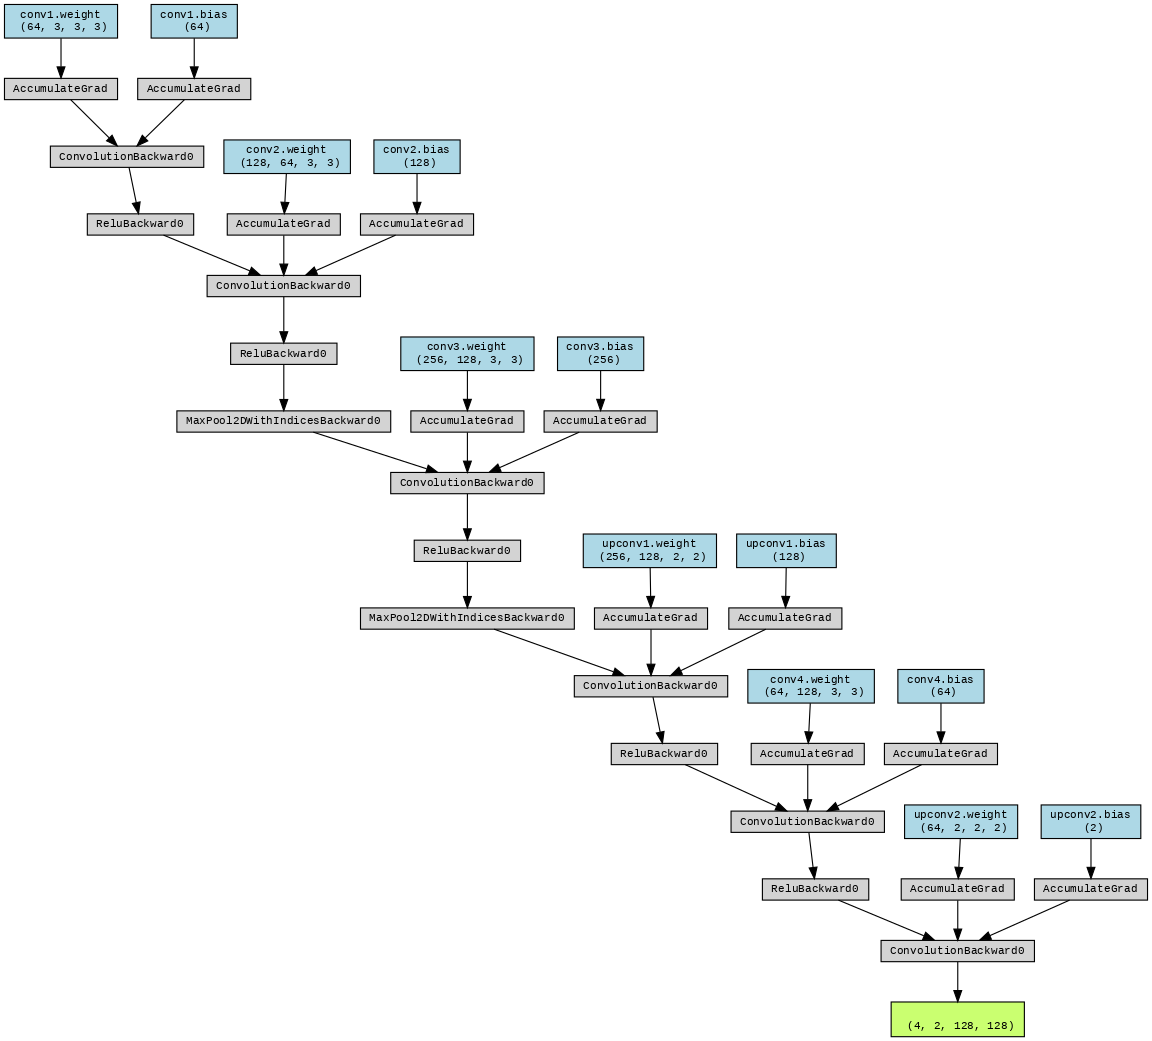


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 10

In [ ]:
print(patch_dir)

/content/CNR-EXT-Patches


In [ ]:
subset_size = 1000  # subset of data to get baseline model running
train_data = torch.utils.data.Subset(train_data, range(subset_size))


In [ ]:
dataloader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=1)

num_epochs = 10  # Smaller number for initial testing
for epoch in range(num_epochs):
    model.train()
    for patches, labels in dataloader:
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/10, Loss: 0.7409421801567078
Epoch 2/10, Loss: 0.4241470396518707
Epoch 3/10, Loss: 0.44099727272987366
Epoch 4/10, Loss: 0.5637992024421692
Epoch 5/10, Loss: 0.7394123673439026
Epoch 6/10, Loss: 0.5676209330558777
Epoch 7/10, Loss: 0.42310598492622375
Epoch 8/10, Loss: 0.6704787015914917
Epoch 9/10, Loss: 0.6615643501281738
Epoch 10/10, Loss: 0.6117562651634216


In [ ]:
train_load = DataLoader(train_data, batch_size=8, shuffle= True)


In [ ]:
print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Batch Size: {dataloader.batch_size}")
print(f"Epochs: {num_epochs}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Loss Function: {criterion.__class__.__name__}")


Learning Rate: 0.001
Batch Size: 8
Epochs: 10
Optimizer: Adam
Loss Function: CrossEntropyLoss


In [ ]:
def calculate_iou(preds, labels):
    preds = torch.argmax(preds, dim=1)  # Convert to class labels
    intersection = (preds & labels).float().sum((1, 2))
    union = (preds | labels).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

# Evaluate Model
model.eval()
total_iou = 0.0

with torch.no_grad():
    for patches, labels in train_load:
        patches, labels = patches.to(device), labels.to(device)
        outputs = model(patches)

        total_iou += calculate_iou(outputs, labels)

print(f"Mean IoU: {total_iou/len(train_load)}")

Mean IoU: 0.7099999785423279


In [ ]:
def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

# Evaluate
total_acc = 0.0
with torch.no_grad():
    for patches, labels in train_load:
        patches, labels = patches.to(device), labels.to(device)
        outputs = model(patches)

        total_acc += pixel_accuracy(outputs, labels)

print(f"Pixel Accuracy: {total_acc/len(train_load):.4f}")


Pixel Accuracy: 0.7100


Next Steps: Implement hyperparamter grid search to find better hyperparamters

# Next Steps are to find the best hyperparameters

import itertools
Hyperparameter grid
learning_rates = [0.0001, 0.0005, 0.001]
batch_sizes = [8, 16]
epochs = [10]

best_loss = float('inf')
best_params = {}

Grid search
for lr, bs, epoch in itertools.product(learning_rates, batch_sizes, epochs):
    print(f"Training with lr={lr}, batch_size={bs}, epochs={epoch}")
    model = UNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
    criterion = dice_loss

    # Run training
    for epoch in range(epoch):
        model.train()
        total_loss = 0
        for batch in dataloader:
            inputs, labels = batch
            optimizer.zero_grad()

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()  # Accumulate loss

        avg_loss = total_loss / len(dataloader)  # Compute average loss per epoch

        # Check if current loss is better than the best loss so far
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = {"learning_rate": lr, "batch_size": bs, "epochs": epoch}